In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, nltk

from nltk.corpus import stopwords
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, average_precision_score,\
                            classification_report, precision_recall_curve,\
                            f1_score, auc, confusion_matrix
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [71]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ddi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /Users/ddi/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ddi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ddi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ddi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /Users/ddi/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/ddi/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [92]:
class NB(object):
    
    
    """
    A class to process data from Kaggle and to predict, whether an E-mail will be classified as Spam or not.
    It is an unbalanced data set for binary classification. Naive-Bayes will be used as the deafault algorithm.
    
    ...

    Attributes
    ----------
    data: pd.DataFrame
          Data to be used for the model
          
    X_train, X_test, y_train, y_test, y_pred: pd.DataFrame
          Features and targets from data; splitted at random data for train and test; 
          target and predicted variables
    
    summary, cm: obj
          The best model from cross-validation; the model for classification with the
          best parameters from the cross-validation phase; summary from the classification;
          the confusion matrix
    
    cv_scores, accuracy, ap_score, precision, recall, thresholds, auc, f1: np.array
          Classification metrics.
    
    Methods
    -------
    load_data():
        Loads the data, filters it and prints its info. Firstly, special characters and stop words
        are removed. Then, from sentiment analysis subjectivity is add as a feature. Finally,
        TfidfVectorizer() is used to form a feature matrix from all words from all e-mails.
            
    split_train_predict(balance = True):
        Performs initialization of Naive-Bayes. If balance is set to True (default), RandomUnderSampler()
        and MultinomialNB() are invoked. If balance is set to False, then ComplementNB() is used instead.
        
    eval_model():
        Evaluates the model performance with y_train. Confusion matrix, Precision-Recall,
        ROC curves and the summary matrix are computed as evaluation metrics. 
        
    """
    
    
    __slots__ = ['data', 'X_train','X_test','y_train','y_test', 'y_pred', 'X', 'y',
                 'accuracy','ap_score','summary', 'precision','recall','thresholds','auc','f1','cm']
    
    
    def __init__(self):
        pass

    
    def load_data(self):
        
        self.data = pd.read_csv('emails.csv')
        
        self.data = self.data.fillna(0)
        
        special_characters = r'[_?!:;,.%#@$\-()[]{}/"<>§±`~^&*=\]'

        for char in special_characters:
            self.data['text'] = self.data['text'].str.replace(char, '')

        stop_words = set(stopwords.words('english'))
        self.data['text'] = self.data['text'].apply(lambda x: ' '.join(word for word in x.split() if word.lower() not in stop_words))
        
        self.data['subjectivity'] = self.data['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)    
        
        tfidf = TfidfVectorizer()
        fm = tfidf.fit_transform(self.data['text'])
        self.data = pd.concat([pd.DataFrame(fm.toarray()),
                               self.data['subjectivity'],
                               self.data['spam']], axis = 1)
        
        print('\nData successfully loaded and filtered\n')
        print('\nNumber of negative class members:\n', len(self.data[self.data['spam'] != 1]))
        print('\nNumber of positive class members:\n', len(self.data[self.data['spam'] == 1]))
        
        
    def split_train_predict(self, balance = True):
        
        if balance == True:
            
            rus = RandomUnderSampler(sampling_strategy = {0:len(self.data[self.data['spam'] == 1]), 
                                                          1:len(self.data[self.data['spam'] == 1])},
                                                          random_state = 42)
            
            self.X, self.y = rus.fit_resample(self.data.iloc[:,:-1].values, self.data.iloc[:,-1])
            
            print('Resampled dataset shape %s' % Counter(self.y))
            
            clf = MultinomialNB(fit_prior = True)


        else:
            
            clf = ComplementNB(fit_prior = True)
            self.X = self.data.iloc[:,:-1].values
            self.y = self.data.iloc[:,-1].values
           
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                train_size = 0.9,
                                                                                test_size =  0.1,
                                                                                random_state = 12)
        
        print('\nTrain data size:\n', self.X_train.shape)
        print('\nTеst data size:\n', self.X_test.shape)
        print('\nTrain label size:\n', self.y_train.shape)
        print('\nTest label size:\n', self.y_test.shape)
            
        
        clf.fit(self.X_train, self.y_train)

        self.y_pred = clf.predict_proba(self.X_test)
        
        self.accuracy = accuracy_score(self.y_test, np.round(self.y_pred[:,1]))
        
        self.ap_score = average_precision_score(self.y_test, np.round(self.y_pred[:,1]),
                                                average = 'micro', pos_label = 1)
        
        print("\nAccuracy: %.2f%%" % (self.accuracy * 100.0))
        print("\nAverage Precision: %.2f%%" % (self.ap_score * 100.0))
        
        
    def eval_model(self):
        
        self.summary = classification_report(self.y_test, np.round(self.y_pred[:,1]))
        print('\nPrecision, recall, accuracy and f1-score:\n', self.summary)
        
        self.precision, self.recall, self.thresholds = precision_recall_curve(self.y_test, np.round(self.y_pred[:,1]))
        
        plt.figure()
        plt.plot(self.recall, self.precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision - Recall Curve')
        plt.show()
        
        self.f1, self.auc = f1_score(self.y_test, np.round(self.y_pred[:,1])), auc(self.recall, self.precision)
        print('\nAUC:', f'{self.auc:.2}')
        
        self.cm = confusion_matrix(self.y_test, np.round(self.y_pred[:,1]))
        print('\nThe confusion matrix:\n', self.cm)

In [93]:
nb = NB()

In [94]:
nb.load_data()

/var/folders/sb/h0gbv1954jlc4qkp7wnc580h0000gn/T/ipykernel_5621/1399463064.py:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  self.data['text'] = self.data['text'].str.replace(char, '')



Data successfully loaded and filtered


Number of negative class members:
 4360

Number of positive class members:
 1368


In [95]:
nb.split_train_predict(balance = True)

Resampled dataset shape Counter({0: 1368, 1: 1368})

Train data size:
 (2462, 37188)

Tеst data size:
 (274, 37188)

Train label size:
 (2462,)

Test label size:
 (274,)

Accuracy: 98.91%

Average Precision: 98.69%



Precision, recall, accuracy and f1-score:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       127
           1       0.99      0.99      0.99       147

    accuracy                           0.99       274
   macro avg       0.99      0.99      0.99       274
weighted avg       0.99      0.99      0.99       274



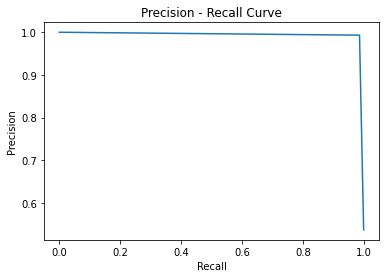


AUC: 0.99

The confusion matrix:
 [[126   1]
 [  2 145]]


In [96]:
nb.eval_model()

In [97]:
nb.split_train_predict(balance = False)


Train data size:
 (5155, 37188)

Tеst data size:
 (573, 37188)

Train label size:
 (5155,)

Test label size:
 (573,)

Accuracy: 95.29%

Average Precision: 85.64%



Precision, recall, accuracy and f1-score:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       429
           1       0.98      0.83      0.90       144

    accuracy                           0.95       573
   macro avg       0.96      0.91      0.93       573
weighted avg       0.95      0.95      0.95       573



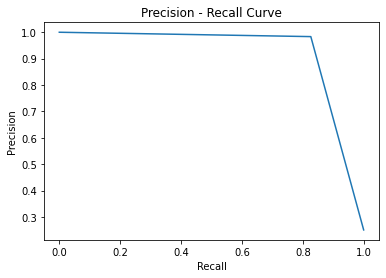


AUC: 0.93

The confusion matrix:
 [[427   2]
 [ 25 119]]


In [98]:
nb.eval_model()